In [192]:
#libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import libs
from scipy.stats import norm
import pandas as pd

In [101]:
# Set global theme settings for plotting
plt.rcParams.update({
    'font.size': 20,          # Set font size
    'lines.linewidth': 3,     # Set default line thickness
    'axes.titlesize': 20,     # Title font size
    'axes.labelsize': 18,     # Axis label font size
    'xtick.labelsize': 14,    # X-tick label font size
    'ytick.labelsize': 14,    # Y-tick label font size
    'grid.color': 'gray',     # Grid color
    'grid.linestyle': '--',   # Grid line style
    'grid.linewidth': 0.5,    # Grid line width
    'legend.fontsize': 16     # Legend font size
})

colorslist = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [175]:
Uds = np.array([2.0])
human_popsize = 10000
iterations = 1000

Kimetalsd = -0.009
Boykoetalsd = -0.029

#x is the number of segregating mutations per individual
Kim_xmean = -Uds/Kimetalsd
Kim_stdv_segregating = np.sqrt(Kim_xmean)

Boyko_xmean = -Uds/Boykoetalsd
Boyko_stdv_segregating = np.sqrt(Boyko_xmean)

R_epistasis = [1.0, 1.025, 1.05]


In [176]:
# Calculate fitness distributions
#for i in range(len(Uds)):
i=0
expected_min_Kim, std_error_min_Kim, expected_max_Kim, std_error_max_Kim = libs.get_expected_min_max_poisson_sample(Kim_xmean[i], human_popsize, iterations)
segregating_mutations = np.linspace(expected_min_Kim, expected_max_Kim, 1000)
pdf = norm.pdf(segregating_mutations, Kim_xmean[i], Kim_stdv_segregating[i])
cdf = norm.cdf(segregating_mutations, Kim_xmean[i], Kim_stdv_segregating[i])
fitness = np.zeros((len(R_epistasis), len(segregating_mutations)))
for j in range(len(R_epistasis)):
    expected_term = libs.get_expected_overA(Kim_xmean[i], expected_min_Kim, expected_max_Kim, R_epistasis[j])
    for k in range(len(segregating_mutations)):
        growth_rate = libs.get_growht_rate(segregating_mutations[k], Kimetalsd, R_epistasis[j], expected_term)
        fitness[j][k] = libs.get_fitness(growth_rate)

# Get the number of epistasis indices and recordings
num_epistasis_indices, num_recordings = fitness.shape
# Flatten the fitness array in row-major order (default)
flattened_fitness = fitness.flatten()
# Repeat each epistasis index for each recording
epistasis = np.repeat(R_epistasis, num_recordings)
#Reapeat the pdf and cdf for each epistasis value (epistasis does not change the load pdf)
pdfs = np.tile(pdf, num_epistasis_indices)
cdfs = np.tile(cdf, num_epistasis_indices)
seg_mutations = np.tile(segregating_mutations, num_epistasis_indices)

# Create the DataFrame
dfitness = pd.DataFrame({
    'Epistasis': epistasis,
    'Fitness': flattened_fitness,
    'logFitness': np.log10(flattened_fitness),
    'Cdfs': cdfs,
    'Pdfs': pdfs,
    'SegregatingMutations': seg_mutations
})

print(dfitness)

      Epistasis   Fitness  logFitness      Cdfs      Pdfs  \
0          1.00  1.642951    0.215625  0.000107  0.000028   
1          1.00  1.641249    0.215174  0.000110  0.000029   
2          1.00  1.639547    0.214724  0.000114  0.000030   
3          1.00  1.637848    0.214274  0.000117  0.000031   
4          1.00  1.636150    0.213823  0.000121  0.000032   
...         ...       ...         ...       ...       ...   
2995       1.05  0.097746   -1.009903  0.999967  0.000009   
2996       1.05  0.096375   -1.016037  0.999968  0.000009   
2997       1.05  0.095015   -1.022206  0.999969  0.000009   
2998       1.05  0.093668   -1.028410  0.999970  0.000009   
2999       1.05  0.092332   -1.034649  0.999971  0.000008   

      SegregatingMutations  
0               167.034000  
1               167.149227  
2               167.264454  
3               167.379682  
4               167.494909  
...                    ...  
2995            281.685091  
2996            281.800318  
2997  

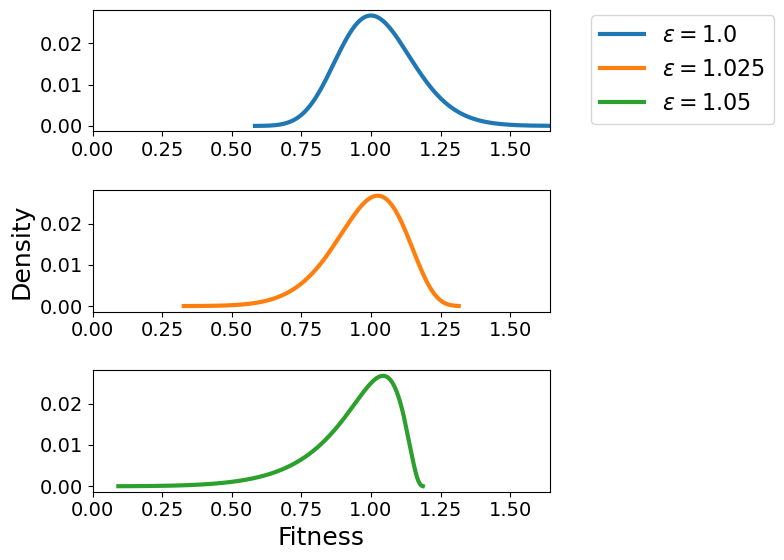

In [205]:
# Get unique epistasis indices
unique_indices = dfitness['Epistasis'].unique()
n = len(unique_indices)

maxfitness = dfitness['Fitness'].max()
# Create subplots
fig, axes = plt.subplots(n, 1, figsize=(6, 2 * n), squeeze=False)

# Plot each subset in the corresponding axis
for i, idx in enumerate(unique_indices):
    ax = axes[i][0]
    
    subset = dfitness[dfitness['Epistasis'] == idx]
    ax.plot(subset['Fitness'], subset['Pdfs'], color=colorslist[i], label=r'$\epsilon=$' + f'{idx}')
    ax.set_xlim(0, maxfitness)

    if i == n - 1:
        ax.set_xlabel('Fitness')

    if i == 1:
        ax.set_ylabel('Density')

# Create custom legend handles
legend_handles = [mpatches.Patch(color=colorslist[i], label= r'$\epsilon=$' + f'{idx}')
                  for i, idx in enumerate(unique_indices)]

fig.legend(loc='upper left', bbox_to_anchor=(1, 0.96))

plt.tight_layout()

fig.savefig('graphs/FitnessPdf_Epistasis.png', bbox_inches='tight') 

plt.show()
plt.close()